In [4]:
import lalpulsar
import lal
import soap
import numpy as np
#import sftscripts
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.signal import spectrogram, medfilt, boxcar
import subprocess
from lalpulsar import simulateCW
from soap import cw
import sys
sys.path.append("/Users/josephbayley/projects/soap_scripts/s6_tests/")
import load_data

In [2]:
#%matplotlib notebook

In [2]:
data_dir = "/Volumes/LaCie/data/soap/"

## load parameters for particular source 

In [7]:
fmin,fmax = 180.2,180.3
par_filenames=["/Volumes/LaCie/data/soap/s6/s6_mdc/SNR_table.txt"]
inj = load_data.read_all(fmin,fmax,filenames=par_filenames)
tstart,T,tsft = 931035615.,22538,1800.
bins = np.arange(fmin,fmax,0.05)
params_doppler = lalpulsar.PulsarDopplerParams()
params_amp = lalpulsar.PulsarAmplitudeParams()
snrH,snrL = 0,0
parfilepath = "/Volumes/LaCie/data/soap/parfiles/"
p_params = []
par = []
for i in inj:
    #print i
    try:
        pname = i["PSR"]
        par = load_data.get_pulsar_params(parfilepath + pname[1:] + '.par')
        p_params = par["Alpha"],par["Delta"],par["phi0"],par["psi"],par["cosi"],par["f"],par['h0']
    except:
        pname = i["#Pulsar"]
        p_params = i["rightascension"], i["declination"], i["phi0"], i["psi"], np.cos(i["iota"]), [i["Frequency"], i["fdot"]], i["h0"]
    snrH = i["SNR(H1)"]
    snrL = i["SNR(L1)"]

    det_name = 'H1'
    params_doppler.fkdot[0] = p_params[5][0]
    params_doppler.fkdot[1] = p_params[5][1]
    params_doppler.refTime  = tstart
    params_doppler.Alpha    = p_params[0]
    params_doppler.Delta    = p_params[1]
    
    params_amp.cosi = p_params[4]
    params_amp.h0 = p_params[6]
    params_amp.phi0 = p_params[2]
    params_amp.psi = p_params[3]


# Inject from time series

In [6]:
def waveform(h0, cosi, freq, f1dot):
    def wf(dt):
        dphi = lal.TWOPI * (freq * dt + f1dot * 0.5 * dt**2)
        ap = h0 * (1.0 + cosi**2) / 2.0
        ax = h0 * cosi
        return dphi, ap, ax
    return wf

In [112]:
# set up parameters
tref     = tstart #900043200
h0       = params_amp.h0*40
cosi     = params_amp.cosi
psi      = params_amp.psi
phi0     = params_amp.phi0
freq     = params_doppler.fkdot[0] + 0.8/1800.
f1dot    = params_doppler.fkdot[1]
dt_wf    = 1./4096
alpha    = params_doppler.Alpha
delta    = params_doppler.Delta
detector = 'H1'
sh       = 1.2918440718232042e-45

In [113]:
edat_p = ["/Users/josephbayley/repositories/soap/soap/earth00-19-DE200.dat.gz","/Users/josephbayley/repositories/soap/soap/sun00-19-DE200.dat.gz"]

In [114]:
# generate waveform
wf = waveform(h0, cosi, freq, f1dot)
S = simulateCW.CWSimulator(tref, tstart, 1*tsft, wf, dt_wf, phi0, psi, alpha, delta, detector,earth_ephem_file=edat_p[0],sun_ephem_file=edat_p[1])

In [115]:
# generate same waveform in and out of noise
ltime,signal = S.get_strain(4096)
ltime,signoise = S.get_strain(4096,noise_sqrt_Sh=np.sqrt(sh))

In [116]:
# get noise by subtracting signal from noise
noise = signoise-signal

In [117]:
# create spectrograms of signal and noise
f,t,signoise_spect = spectrogram(signoise.astype(float),fs = 4096, nperseg=int(tsft*4096),noverlap=0,window=("boxcar"))

In [118]:
# generate spectrograms for noise and signal
fsig,tsig,sig_spect = spectrogram(signal,fs = 4096., nperseg=int(tsft*4096),noverlap=0.0,window=("boxcar"))
f_noise,t_noise,noise_spect = spectrogram(noise.astype(float),fs = 4096. , nperseg=int(tsft*4096), noverlap=0.0,window=("boxcar"))

Testing the signal

In [119]:
padsig = np.append(signal,np.zeros(20*len(signal)))

In [120]:
bcar = boxcar(len(padsig))

In [121]:
fftsig = np.fft.rfft(padsig*bcar)

In [122]:
freqsig = np.fft.rfftfreq(len(padsig),1./4096.)

In [123]:
sp_sig = np.array(np.abs(fftsig/(len(padsig)))**2)

In [124]:
fftnoise = np.fft.rfft(noise[:1800*4096])
sp_noise = np.abs(fftnoise)**2

In [125]:
np.mean(sp_noise/(len(fftnoise)*4096.))

1.2913831963761202e-45

In [126]:
# snr calculation from spectrograms
snr = 0
for i in range(1):
    snr += np.sum(sig_spect[:,i]/noise_spect[:,i])
print(np.sqrt(snr))

20.67846260799673


In [127]:
sig = cw.GenerateSignal()
sig.alpha = alpha
sig.delta = np.arcsin(delta)
sig.cosi = cosi
sig.phi0 = phi0
sig.psi = psi
sig.f = [freq,f1dot]
sig.earth_ephem = "/Users/josephbayley/repositories/soap/soap/earth00-19-DE200.dat.gz"
sig.sun_ephem = "/Users/josephbayley/repositories/soap/soap/sun00-19-DE200.dat.gz"
sig.tref = tref
sig.h0 = h0

In [128]:
data = sig.get_spectrogram(tstart = tstart, nsft = 1,tsft=1800,fmin=freq-0.05,fmax=freq+0.05,dets= ["H1"],Sn={"H1":sh})

signal SNR

In [129]:
stfreq  = sig.get_pulsar_path([tstart + 900],'H1')

In [130]:
snr = sig.get_snr2(tstart=tstart,tsft=1800.,nsft=1,det="H1",Sn=sh)

In [131]:
print(np.sqrt(snr))

24.954271396777187


In [132]:
fullfreqs = np.arange(0,180.3,1./1800)
freqvals = np.linspace(fullfreqs[np.argmin(np.abs(fullfreqs-180.2))],fullfreqs[-1],5000)
values = sig.fresnel_power(freqvals,stfreq,1800.,f1dot)*snr

In [133]:
#maxval = max(2*sig_spect[fmin_ind1:fmax_ind1,0]/sh)

In [134]:
#diff = np.linspace(180.2,180.3,10000)[np.argmin(np.abs(values - maxval))] - fsig[fmin_ind1:fmax_ind1][np.argmin(np.abs(2*sig_spect[fmin_ind1:fmax_ind1,0]/sh - maxval))]
                                                                                               

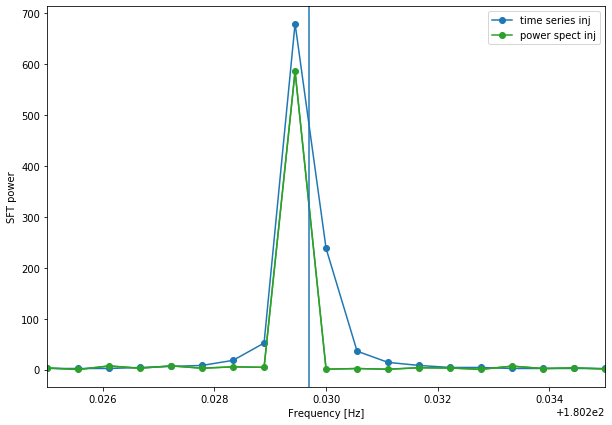

In [135]:
fig,ax = plt.subplots(figsize=(10,7))


#fmin_ind = np.argmin(np.abs(freqsig-fmin))#np.where(freqsig == fmin)[0][0]
#fmax_ind = np.argmin(np.abs(freqsig-fmin))#np.where(freqsig == fmax)[0][0]
fmin_ind1 = np.where(fsig == fmin)[0][0]
fmax_ind1 = np.where(fsig == fmax)[0][0]
#ax.plot(fsig[fmin_ind1:fmax_ind1],2*sig_spect[fmin_ind1:fmax_ind1,0]/sh,color="C0")
ax.plot(fsig[fmin_ind1:fmax_ind1],2*sig_spect[fmin_ind1:fmax_ind1,0]/sh,label="time series inj",marker="o",color="C0")
#ax.plot(freqsig[fmin_ind:fmax_ind],2*sp_sig[fmin_ind:fmax_ind]/sh)
#ax.plot(freqvals ,np.array(values),color="C1")

ax.plot(data.H1.frequencies,data.H1.norm_sft_power[0],color="C2")
ax.plot(data.H1.frequencies,data.H1.norm_sft_power[0],label="power spect inj",color="C2",marker="o")
#ax.plot(my_data[0][0])
#ax.plot(noise_spect[:,0])
#ax.plot(signoise[:100])
#ax.plot(noise[:100])
#ax.plot(np.abs(np.fft.rfft(noise[:int(0.5*len(noise))]))**2)
#ax.axvline(my_data[1][0],color="r")
#ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("SFT power")
#ax.set_xlim(fmin,fmax)
ax.set_xlim(180.225,180.235)
ax.axvline(stfreq)
ax.legend()

In [101]:
max(sp_sig[fmin_ind:fmax_ind]),max(values)

(4.701038431138235e-49, 621.7421234662123)

In [111]:
max(sp_sig[fmin_ind:fmax_ind]/sh)

0.0003639013820378159

No handles with labels found to put in legend.


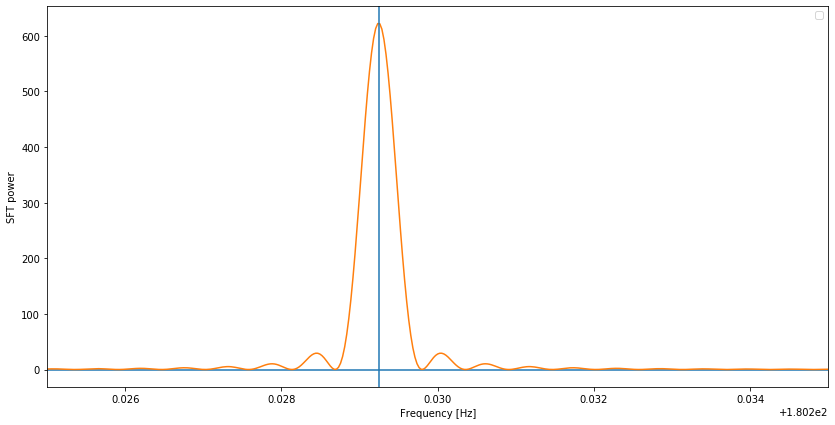

In [94]:
fig,ax = plt.subplots(figsize=(14,7))

fmin_ind = np.argmin(np.abs(freqsig-fmin+0.05))#np.where(freqsig == fmin)[0][0]
fmax_ind = np.argmin(np.abs(freqsig-fmax-0.05))#np.where(freqsig == fmax)[0][0]
fmin_ind1 = np.where(fsig == fmin)[0][0]
fmax_ind1 = np.where(fsig == fmax)[0][0]

#ax.plot(freqsig,fftsig,label="time series inj",marker="o",color="C0")
dt = (freqsig[2] -freqsig[1])
ax.plot(freqsig[fmin_ind:fmax_ind] ,2*sp_sig[fmin_ind:fmax_ind]/sh,color="C0")

freqvals = freqsig[fmin_ind:fmax_ind]
values = sig.fresnel_power(freqvals,stfreq,1800.,f1dot)*snr

ax.plot(freqvals ,np.array(values),color="C1")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("SFT power")
#ax.set_xlim(fmin,fmax)
ax.set_xlim(180.225,180.235)
ax.axvline(stfreq)
ax.legend()

In [17]:
soap.gen_data.fresnel_power?

<IPython.core.display.Javascript object>


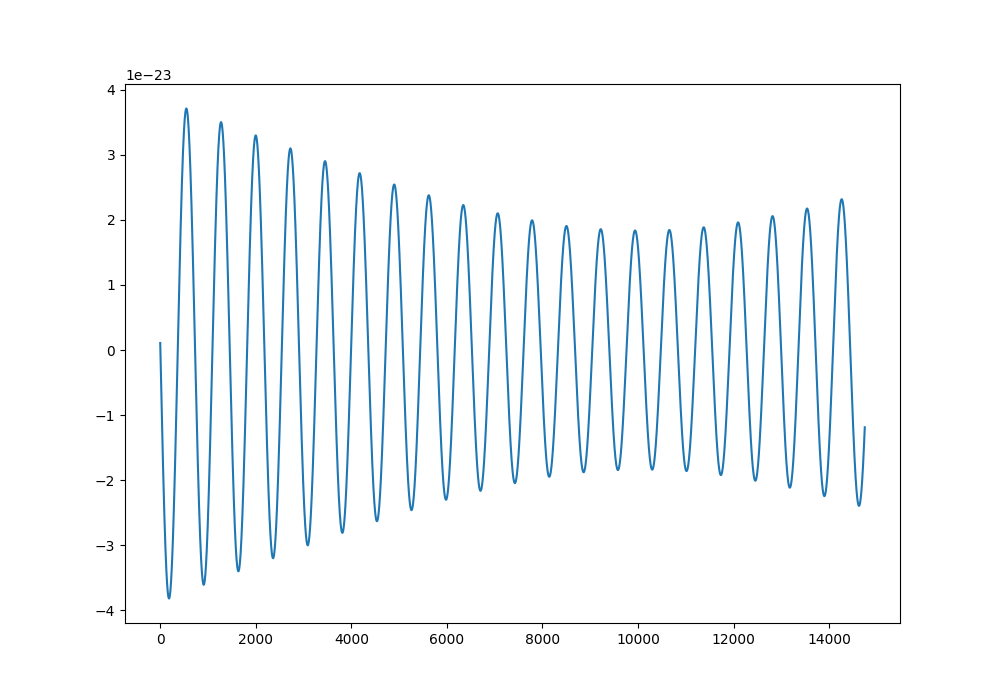

In [169]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(signal[::1000])

## Sine wave and sinc function

In [254]:
freq_sin = 50
nsamp = 1000
xvals = np.linspace(0,1,nsamp)
fs = 1/(1/nsamp)
sinvals = np.append(np.sin(2*np.pi*freq_sin*xvals),np.zeros(10000))
xvals2 = np.linspace(0,2,len(sinvals))

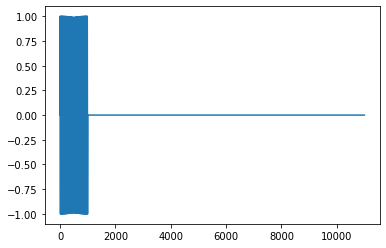

In [255]:
fig, ax = plt.subplots()
ax.plot(sinvals)

In [274]:
powspec = np.abs(np.fft.rfft(sinvals)**2)
powfreq = np.fft.rfftfreq(len(sinvals),1./fs)

In [322]:
dt = powfreq[10] - powfreq[9]

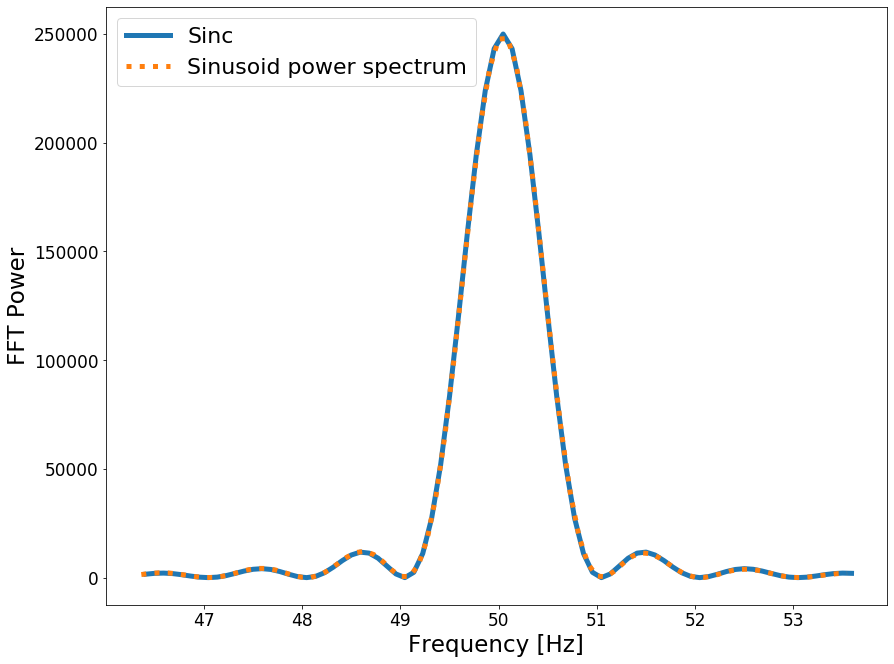

In [343]:
fig, ax = plt.subplots(figsize=(14,11))
fontsize = 23
fstind,fenind = 510,590
sincx = powfreq[fstind:fenind]
sinc = np.abs(np.sinc(powfreq[fstind:fenind] - freq )*0.5*fs)**2
ax.plot(powfreq[fstind:fenind] + 0.5*dt,sinc,ls="-",lw=5,label="Sinc")
ax.plot(sincx,powspec[fstind:fenind],lw=5,ls=":",label="Sinusoid power spectrum")
#ax.plot(powfreq,powspec)
ax.legend(fontsize=fontsize-1)
ax.set_xlabel("Frequency [Hz]",fontsize=fontsize)
ax.set_ylabel("FFT Power",fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=17)


In [344]:
fig.savefig("/Users/josephbayley/projects/thesis/AppendixA/sinc_fft.pdf",format="pdf",bbox_inches="tight")

# Sin with spindown

Start with definition of fourier transform as in [https://iopscience.iop.org/article/10.1086/342285/meta].
Discrete Fourier transform,
\begin{equation}
 A_k = \sum_{j = 0}^{N-1} n_j e^{-i2 \pi j k/N},
\end{equation}
the frequency of kth element is,
\begin{equation}
f_k = \frac{k}{N dt} = \frac{k}{T}
\end{equation}
where k is the frequency bin number, N is the number of data points, T is the total time duration.
The frequency spacing is $1/T$, $N/2T$ is the nyquist frequency.

Can then define a value $u$, this is the fraction of time between the start and end of observation.
i.e T becomes 1. and $u = t/T$, so $0 \leq u \leq 1$.
this also means that $f = r/T$ and $\dot{f}=\dot{r}T^2$
One can then define the continuous Fouier transform (if large data) in terms of $u$ as,
\begin{equation}
A_r = N \int^{1}_{0} n(u) e^{-i2 \pi r u} du.
\end{equation}

Start with a signal definition,
\begin{equation}
\begin{split}
n(u) &= a \cos{2\pi (r_0 u + 1/2 \dot{r} u^2) + \phi} \\
&= \frac{1}{2} a \left[ e^{i 2\pi(r_0 u + 1/2 \dot{r} u^2)}e^{i\phi}  + e^{-i 2\pi(r_0 u + 1/2 \dot{r} u^2)}e^{-i\phi}    \right] \\
\end{split}
\end{equation}
Then the Fourier transform as above can be written as,
\begin{equation}
A_{r_c} = \frac{aN}{2} e^{i\phi} \left[ \int_{0}^{1} e^{i 2 \pi(\frac{\dot{r}}{2} u^2 + r_{0c}u - r_cu)} du  + \int_{0}^{1} e^{-i 2 \pi(\frac{\dot{r}}{2} u^2 + r_{0c}u + r_cu)} du\right] = \frac{aN}{2} e^{i\phi} \left[  I_1 + I_2   \right],
\end{equation}
where $r_c = r + \dot{r}/2$ and the signal frequency at bin center is $r_{0c} = r_0 + \dot{r}/2$.
The first integral can then be written as,
\begin{equation}
\begin{split}
I_1 &= \int_{0}^{1} \exp{\left\{i 2 \pi(\frac{\dot{r}}{2} u^2 + r_{0c}u - r_cu) \right\}} du \\
 &= \int_{0}^{1} \exp{\left\{ i 2 \pi\left(\frac{\dot{r}}{2} u^2 + (r_{0c} - r_c)u \right) \right\}} du \\
 & = \int_{0}^{1} \exp{\left\{i \frac{\pi}{2} 2 \dot{r} \left(u^2 + 2\frac{(r_{0c} - r_c)}{\dot{r}}u \right)\right\}} du \\
  & = \int_{0}^{1} \exp{\left\{i \frac{\pi}{2} 2 \dot{r} \left[\left(u + \frac{(r_{0c} - r_c)}{\dot{r}} \right)^2 - \left(\frac{(r_{0c} - r_c)}{\dot{r}}\right)^2 \right]\right\}} du \\
    & = \exp{\left\{  - i \frac{\pi}{2} 2 \dot{r} \left(\frac{(r_{0c} - r_c)}{\dot{r}}\right)^2 \right\}}\int_{0}^{1} \exp{\left\{i \frac{\pi}{2} 2 \dot{r} \left[\left(u + \frac{(r_{0c} - r_c)}{\dot{r}} \right)^2 \right]\right\}} du \\
\end{split}
\end{equation}
We cna then substitute using,
\begin{equation}
v = \sqrt{2\dot{r}}\left( u + \frac{(r_{0c} - r_c)}{\dot{r}}  \right)
\end{equation}
where,
\begin{equation}
dv = \sqrt{2\dot{r}} du 
\end{equation}
and when $u = 1$ we can define $Y$ as,
\begin{equation}
Y = \sqrt{2\dot{r}}\left( 1 + \frac{(r_{0c} - r_c)}{\dot{r}}  \right)
\end{equation}
The integral then becomes,
\begin{equation}
\begin{split}
I_1 & = \exp{\left\{  - i \frac{\pi}{2} 2 \dot{r} \left(\frac{(r_{0c} - r_c)}{\dot{r}}\right)^2 \right\}} \sqrt{2\dot{r}}  \int_{0}^{Y} \exp{\left\{i \frac{\pi}{2} v^2\right\}} dv \\
& = \exp{\left\{  - i \frac{\pi}{2} 2 \dot{r} \left(\frac{(r_{0c} - r_c)}{\dot{r}}\right)^2 \right\}} \sqrt{2\dot{r}}  \int_{0}^{Y} 
\cos{\left(  \frac{\pi}{2} v^2 \right)} + i\sin{\left(  \frac{\pi}{2} v^2 \right)} dv \\
\end{split}
\end{equation}
Similarly, using,
\begin{equation}
Z = \sqrt{2\dot{r}}\left( 1 - \frac{(r_{0c} - r_c)}{\dot{r}}  \right)
\end{equation}
one can write,
\begin{equation}
\begin{split}
I_2 & = \exp{\left\{  - i \frac{\pi}{2} 2 \dot{r} \left(\frac{(r_{0c} - r_c)}{\dot{r}}\right)^2 \right\}} \sqrt{2\dot{r}}  \int_{0}^{Z} \exp{\left\{i \frac{\pi}{2} v^2\right\}} dv \\
& = \exp{\left\{  - i \frac{\pi}{2} 2 \dot{r} \left(\frac{(r_{0c} - r_c)}{\dot{r}}\right)^2 \right\}} \sqrt{2\dot{r}}  \int_{0}^{Z} 
\cos{\left(  \frac{\pi}{2} v^2 \right)} + i\sin{\left(  \frac{\pi}{2} v^2 \right)} dv \\
\end{split}
\end{equation}

One can then use the fresnel $S(x)$ and $C(x)$ defined by,
\begin{equation}
\begin{split}
C(x) &= \int_0^x \cos{\frac{\pi}{2} t^2} dt \\
S(x) &= \int_0^x \sin{\frac{\pi}{2} t^2} dt \\
\end{split}
\end{equation}
The fourier transform is then,
\begin{equation}
  A_{r_c} = \frac{aN}{2\sqrt{2\dot{r}}} e^{i(\phi - \pi q^2/\dot{r})} \left[ S(Z) -  S(Y) + i(C(Y) - C(Z))   \right],
\end{equation}
where,
The power spectrum is then,
\begin{equation}
  |A_{r_c}|^2 = \frac{a^2 N^2}{4\dot{r}}  \left[ (S(Z) -  S(Y))^2 + (C(Y) - C(Z))^2   \right]
\end{equation}

This can then be converted back into frequencies using the raltions in ....,
\begin{equation}
  |A_{r_c}|^2 = \frac{a^2 N^2}{4\dot{f}T^2}  \left[ (S(Z) -  S(Y))^2 + (C(Y) - C(Z))^2   \right]
\end{equation}
and,
\begin{equation}
\begin{split}
Z &= \sqrt{2\dot{f}}T\left( 1 - \frac{(f_{0c} - f_c)}{\dot{f}T}  \right) \\
Y &= \sqrt{2\dot{f}}T\left( 1 + \frac{(f_{0c} - f_c)}{\dot{f}T}  \right) \\
\end{split}
\end{equation}

In [1]:
from scipy.special import fresnel

In [570]:
def fresnel_power(f,f0,tsft,fdot):
    
    #f0 = f0 + fdot*10
    
    #fdot = np.abs(fdot)
    Y = np.sqrt(fdot/2.0)*tsft*(1+(2.0*(f-f0)/(fdot*tsft)))
    Z = np.sqrt(fdot/2.0)*tsft*(1-(2.0*(f-f0)/(fdot*tsft)))
    
    #Y = np.sqrt(2.0/rdot)*(r0-r)
    #Z = np.sqrt(2.0/rdot)*(r0-r + rdot)
    
    S1,C1 = fresnel(Y)
    S2,C2 = fresnel(Z)
    Sw2 = (1/(2*fdot*tsft*tsft))*((C1+C2)**2 + (S1+S2)**2) 
    #Sw2 = ((C1+C2)**2 + (S1+S2)**2) 
    return Sw2

In [693]:
f = 200
fdot = 1e-10
fs = 4000
dt = 1./fs
tlen = 18
datalen = fs*tlen

In [694]:
t = np.linspace(0,tlen,datalen)
nt = np.cos(2*np.pi*(f*t + fdot*t*t/2))

In [695]:
padnt = np.append(nt,np.zeros(900000))

In [696]:
nf = np.abs(np.fft.rfft(padnt))**2
frs = np.fft.rfftfreq(len(padnt),dt)

In [697]:
diff = frs[1] - frs[0]

In [698]:
1./diff

242.99999999999997

In [699]:
pws = fresnel_power(frs,f,tlen,fdot)*datalen*datalen/4

In [700]:
stbin,enbin = int((f - 0.1)*1./diff),int((f + 0.1)*1./diff)

In [701]:
maxfreqnf  = frs[stbin:enbin][np.argmax(nf[stbin:enbin])]
maxfreqpws = frs[stbin:enbin][np.argmax(pws[stbin:enbin])]

In [702]:
print(maxfreqnf - maxfreqpws)
print(fdot)

0.004115226337432887
1e-10


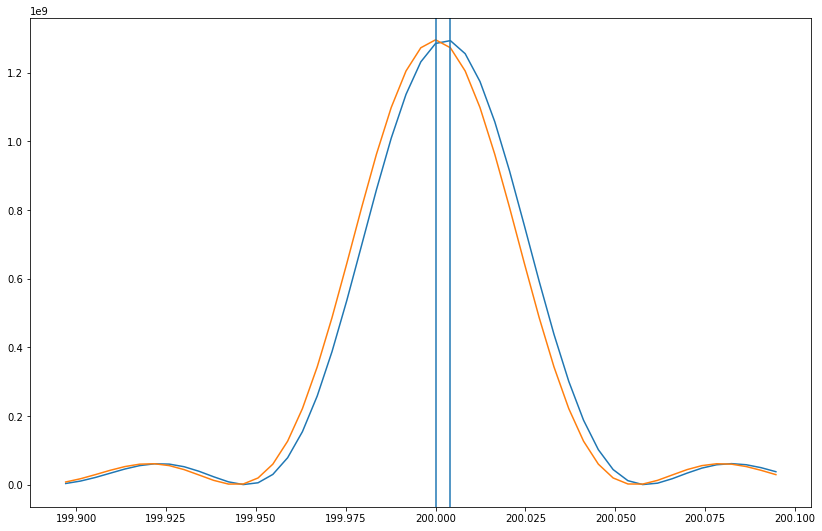

In [703]:
fig, ax = plt.subplots(figsize=(14,9))
ax.plot(frs[stbin:enbin],nf[stbin:enbin])
ax.plot(frs[stbin:enbin],pws[stbin:enbin])
ax.axvline(maxfreqnf)
ax.axvline(maxfreqpws)